TODO 

rework the dataframe to different feature approach...not based aggregates but 'activity per day'



# Basic classification models

* initial objectives:
  * fit several base models
  * candidates:  `logistic regression`, `decision tree`, `svm`, `random forest`, `gradient boosting`, `knn`, `naive bayes`, `neural networks`
  * 

## Import libraries and load functions

In [1]:
# import
import pandas as pd
from sklearn.preprocessing import StandardScaler

### functions
- [x] extract depresjon from folder
- [x] extract full days (1440 rows) records and minimum full records
- [ ] resample, e.g. to hourly
- [x] normalise data (mean = 0, std = 1)
- [ ] 

In [2]:
# load pl functions

%run ../code/pl-functions.py

## Data preprocessing

### Extract data from folder

In [3]:
# load the data
df = extract_folder('../data/depresjon')

In [4]:
# print head
#print(df.head())

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 60.0+ MB
None


### Reduce dataset to full days only


In [5]:
# extract full days
df7 = extract_full_days(df, 7)

In [6]:
# print rows per id / 1440
#print(df7.groupby('id').size()/1440)

# print unique count of id
print(df7['id'].nunique())

# print days for each id
#num_days = df.groupby('id')['date'].nunique()
#print(num_days)

# print date range for condition_1 id
print(df7[df7['id'] == 'condition_1']['date'].min())
print(df7[df7['id'] == 'condition_1']['date'].max())

# print info
print(df7.info())



55
2003-05-08
2003-05-23
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527281 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1527281 non-null  datetime64[ns]
 1   date       1527281 non-null  object        
 2   activity   1527281 non-null  int64         
 3   id         1527281 non-null  object        
 4   label      1527281 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 69.9+ MB
None


### Resample - 

* I am skipping this optional step for now...I want to see if it runs on the complete df

### Normalise

In [7]:
# column to normalise
col_to_normlise = ['activity']

# normalise
df7_norm = normalise_data(df7, col_to_normlise)


C:\Users\zoona\OneDrive - UWE Bristol\DS Year 2\IGP-5\code\pl-functions.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])


In [8]:
# print head
#print(df.head())

# print info
print(df7_norm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527281 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1527281 non-null  datetime64[ns]
 1   date       1527281 non-null  object        
 2   activity   1527281 non-null  float64       
 3   id         1527281 non-null  object        
 4   label      1527281 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 69.9+ MB
None


### Feature engineering

This model is based on 'day activity' and basic aggregations, e.g. mean, sum, std, etc.

In [19]:
import numpy as np

#  empty lists for activity data and each additional feature
activity_data_list = []
mean_activity_list = []
sum_activity_list = []
max_activity_list = []
min_activity_list = []
std_activity_list = []
y = []

#  unique IDs
ids = df7_norm['id'].unique()

# iterate over each ID
for id in ids:
    # data for this ID
    df_id = df7_norm[df7_norm['id'] == id]

    #  unique dates
    dates = df_id['date'].unique()

    # iterate over each date
    for date in dates:
        #  data for this date
        df_date = df_id[df_id['date'] == date]

        # check if there are 1440 minutes of data for this date
        if len(df_date) < 1440:
            # Fill missing data with 0s
            activity_data = np.zeros(1440)
            activity_data[:len(df_date)] = df_date['activity'].values
        else:
            activity_data = df_date['activity'].values

        #  additional features
        mean_activity = np.mean(activity_data)
        sum_activity = np.sum(activity_data)
        max_activity = np.max(activity_data)
        min_activity = np.min(activity_data)
        std_activity = np.std(activity_data)

        # append activity data and additional features to their list
        activity_data_list.append(activity_data)
        mean_activity_list.append(mean_activity)
        sum_activity_list.append(sum_activity)
        max_activity_list.append(max_activity)
        min_activity_list.append(min_activity)
        std_activity_list.append(std_activity)
        y.append(df_date['label'].iloc[0])

# convert lists to numpy arrays
X_activity_data = np.array(activity_data_list)
X_mean_activity = np.array(mean_activity_list)
X_sum_activity = np.array(sum_activity_list)
X_max_activity = np.array(max_activity_list)
X_min_activity = np.array(min_activity_list)
X_std_activity = np.array(std_activity_list)
y = np.array(y)



## Train / Test split

In [21]:
from sklearn.model_selection import train_test_split

# combine feature arrays into a single 2D array
X = np.column_stack((X_activity_data, X_mean_activity, X_sum_activity, X_max_activity, X_min_activity, X_std_activity))


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Models

**Logistic Regression:**
LR is a statistical model used in binary classification by modelling the log-odds of the probability of an event.
* Strengths: Simple, fast, and efficient for small dataset with limited features.
* Weaknesses: Assumes a linear decision boundary, can underperform with complex datasets.

**Random Forest:**
* RF is an ensemble learning method constructs multiple decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
* Strengths: Handles categorical variables well, resistant to overfitting, can model non-linear decision boundaries.
* Weaknesses: *Can be slow on large datasets*, not easily interpretable.

**Support Vector Machine (SVM):**
* SVM is a powerful and flexible class of supervised algorithms for both classification and regression.
* Strengths: Effective in high dimensional spaces, or when number of dimensions is greater than the number of samples.
* Weaknesses: Does not directly provide probability estimates, can be *inefficient to train*.
  
**Decision Tree:**
* DT are a type of simple flowchart-like structure in which internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.
* Strengths: Simple to understand and interpret, requires little data preparation.
* Weaknesses: Prone to overfitting, can create biased trees if some classes dominate.

**K-Nearest Neighbors (KNN):**
* KNN is a type of *instance-based learning, or lazy learning*, where the function is only approximated locally and all computation is deferred until function evaluation.
* Strengths: Simple, effective for datasets with complex decision boundaries.
* Weaknesses: *Slow on large datasets*, sensitive to irrelevant features.

**Naive Bayes:**
* NB classifiers are a family of simple “probabilistic classifiers” based on applying Bayes’ theorem with strong (naïve) independence assumptions between the features.
* Strengths: Fast, simple, performs well with small datasets.
* Weaknesses: *Assumes that all features are independent*, which is rarely the case.

**Neural Network (MLPClassifier):**
* MLPClassifier stands for Multi-layer Perceptron classifier connects to a Neural Network. MLPClassifier relies on an underlying Neural Network to perform the task of classification.
* Strengths: Can model complex, non-linear patterns.
* Weaknesses: *Requires a lot of data and computational resources, not easily interpretable.*

**XGBoost**:
* XGBoost is an optimised distributed gradient boosting library designed to be highly efficient, flexible and portable.
* Strengths: Fast, accurate, supports regularisation to avoid overfitting.
* Weaknesses: *Can be slow to train*, not easily interpretable.

**LightGBM**:
* LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages: Faster training speed and higher efficiency, lower memory usage, better accuracy, support of parallel and GPU learning, capable of handling large-scale data.
* Strengths: Fast, uses less memory, higher accuracy.
* Weaknesses: Can overfit on small datasets, not easily interpretable.

**AdaBoost**:
* AdaBoost is a boosting algorithm which constructs a classifier. Adaboost creates a strong classifier from number of weak classifiers.
* Strengths: Fast, simple, less prone to overfitting.
* Weaknesses: Sensitive to noisy data and outliers.

**Quadratic Discriminant Analysis (QDA):**
* QDA is a classifier with a quadratic decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
* Strengths: Can model more complex decision boundaries than linear methods.
* Weaknesses: *Assumes that the observations are normally distributed*, which is rarely the case.

In [ ]:
#%pip install xgboost
#%pip install lightgbm

## Import model libraries

In [22]:
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix


## Set up models, in sets (not sure how long they take to run)

In [49]:
# full set
models = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier())
]


# models set 1
models1 = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),    
]


models_2 = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    
]

models_3 = [
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),  
]

models_4 = [
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()), 
    ('Gradient Boosting', GradientBoostingClassifier())
]

## Model evaluation function

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
import time

def evaluate_models_with_cv(models, X_train, y_train, X_test, y_test, print_results=True):
    """
    Evaluate multiple models using cross-validation and generate predictions on the test data.

    Parameters:
    - models (list): A list of tuples containing the name and model object for each model to be evaluated.
    - X_train (array-like): The training data features.
    - y_train (array-like): The training data labels.
    - X_test (array-like): The test data features.
    - y_test (array-like): The test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    Each dictionary contains the following keys:
        - 'name': The name of the model.
        - 'time': The time taken to train and predict.
        - 'accuracy': The accuracy score.
        - 'precision': The precision score.
        - 'recall': The recall score.
        - 'f1': The F1 score.
        - 'mcc': The Matthews Correlation Coefficient.
        - 'confusion_matrix': The confusion matrix.
        - 'classification_report': The classification report.
        - 'auc_roc': The AUC-ROC (if the model has a predict_proba method).
    """

    results = []

    for name, model in models:
        start_time = time.time()

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f'{name} cross-validation score: {cv_scores.mean()} ± {cv_scores.std()}')

        # Fit the model on the training data and generate predictions on the test data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        # Create a dictionary for the results
        result = {
            'name': name,
            'time': time.time() - start_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr
        }

        # Check if the model has a predict_proba method
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_scores)
            result['auc_roc'] = roc_auc
            result['y_scores'] = list(y_scores) 

        # Append the dictionary to the list
        results.append(result)

    return results


## Models

In [57]:
# evaluate models
results = evaluate_models_with_cv(models, X_train, y_train, X_test, y_test, print_results=False)

Random Forest cross-validation score: 0.7603747259318318 ± 0.030939329147260154
SVM cross-validation score: 0.7292870905587667 ± 0.017824065725396087
Decision Tree cross-validation score: 0.6681482957942994 ± 0.030584083459225968
Logistic Regression cross-validation score: 0.612849644541891 ± 0.03422634758244854
KNN cross-validation score: 0.6924191083648927 ± 0.0152464321852745
Naive Bayes cross-validation score: 0.5806989568799414 ± 0.0335749558208365
Neural Network cross-validation score: 0.6727858614045579 ± 0.02260916370579479
XGBoost cross-validation score: 0.7626669324297388 ± 0.022053765717683048
[LightGBM] [Info] Number of positive: 242, number of negative: 452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141069
[LightGBM] [Info] Number of data points in the train set: 694, number of used features: 1445
[LightGBM] [Info] [binary:Boos

c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA cross-validation score: 0.4204836887914424 ± 0.020712323081167328


c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gradient Boosting cross-validation score: 0.7384226961663677 ± 0.024924632269865358


In [58]:
# results to dataframe
df_results = pd.DataFrame(results)

# print top 3 of each metric
for column_label in df_results.columns[1:7]:
    print(column_label)
    print(df_results.sort_values(by=column_label, ascending=False).head(3)[['name', column_label]])
    print('\n\n')

time
                 name       time
11  Gradient Boosting  93.191835
6      Neural Network  24.093033
9            AdaBoost  17.949909



accuracy
                 name  accuracy
11  Gradient Boosting  0.770642
8            LightGBM  0.761468
0       Random Forest  0.747706



precision
                 name  precision
11  Gradient Boosting   0.661972
0       Random Forest   0.645161
8            LightGBM   0.643836



recall
           name    recall
10          QDA  0.972603
5   Naive Bayes  0.698630
8      LightGBM  0.643836



f1
                 name        f1
11  Gradient Boosting  0.652778
8            LightGBM  0.643836
7             XGBoost  0.620690



mcc
                 name       mcc
11  Gradient Boosting  0.481698
8            LightGBM  0.464525
7             XGBoost  0.431723





In [59]:
# print classification report for eaach model 
for i in range(0, len(df_results)):
    print(df_results['name'][i])
    print(df_results['classification_report'][i])
    print('\n\n')


Random Forest
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       145
           1       0.65      0.55      0.59        73

    accuracy                           0.75       218
   macro avg       0.72      0.70      0.70       218
weighted avg       0.74      0.75      0.74       218




SVM
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       145
           1       0.52      0.44      0.48        73

    accuracy                           0.68       218
   macro avg       0.63      0.62      0.62       218
weighted avg       0.67      0.68      0.67       218




Decision Tree
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       145
           1       0.52      0.55      0.53        73

    accuracy                           0.68       218
   macro avg       0.64      0.65      0.64       218
weighted avg       0.68      0.68   

## Visualise results


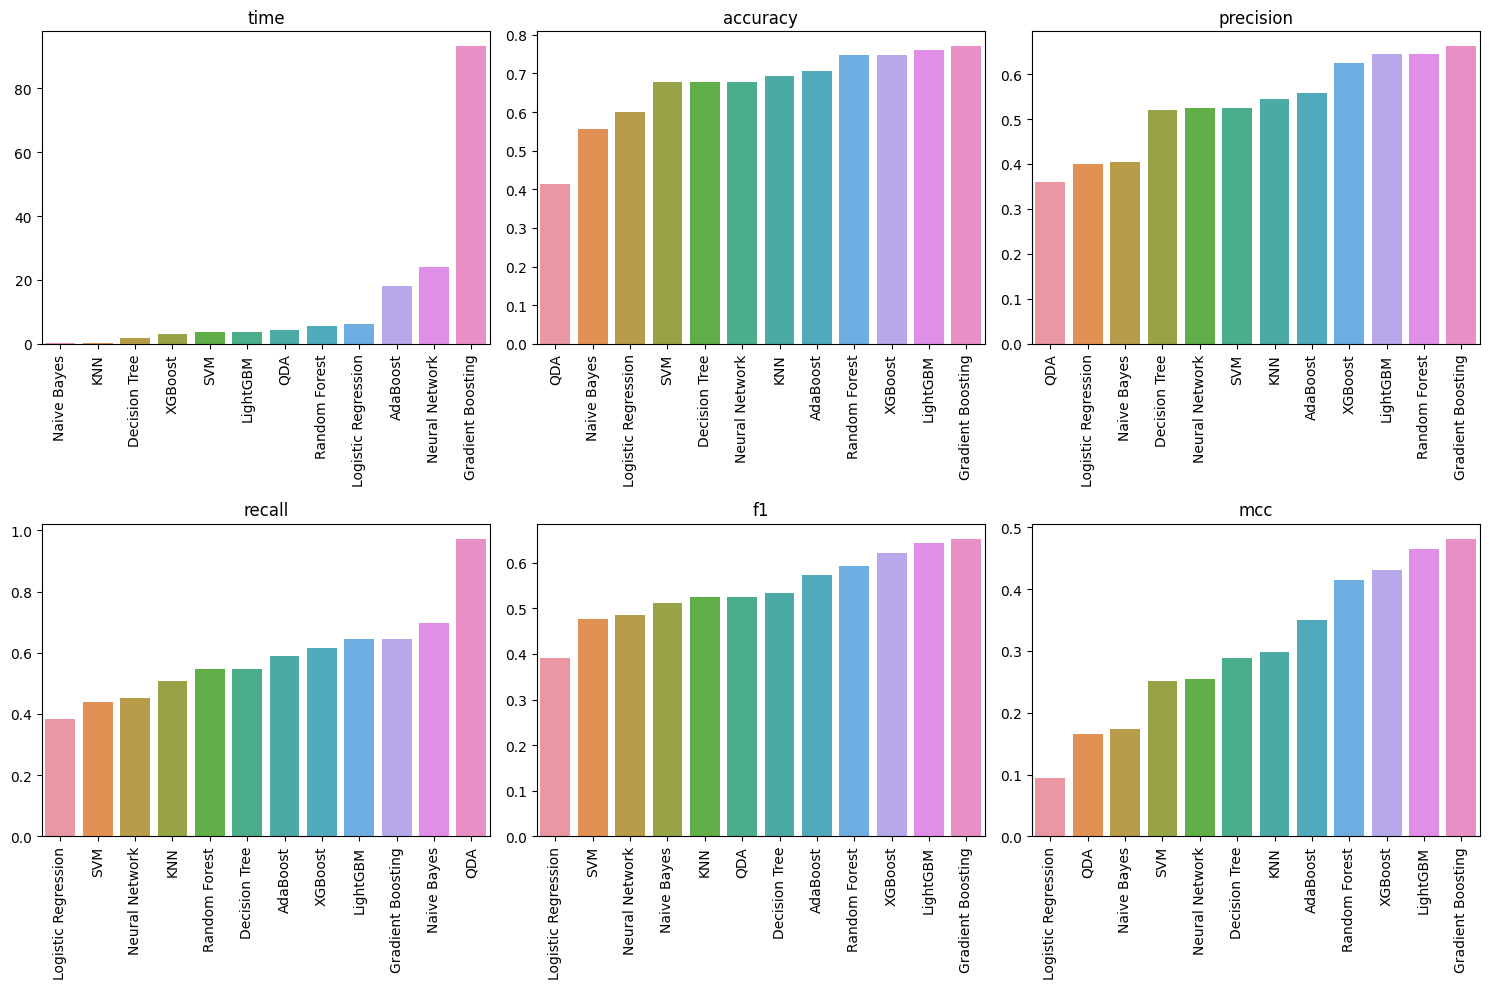

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# results to dataframe
#df_results = pd.DataFrame(results)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# List of metrics
metrics = ['time', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
labels = ['Time', 'Scores', 'Scores', 'Scores', 'Scores', 'Scores']

# Plot each metric
for i, metric in enumerate(metrics):
    row = i // 3 # Integer division to convert i into a row index
    col = i % 3 # Modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = df_results.sort_values(metric)  # sort by the current metric
    sns.barplot(data=df_sorted, x='name', y=metric, ax=ax) 
    ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted DataFrame
    ax.set_title(metric)
    ax.set_xlabel('')  # Remove x-axis title
    ax.set_ylabel('')  # Remove y-axis title

plt.tight_layout()
plt.show()




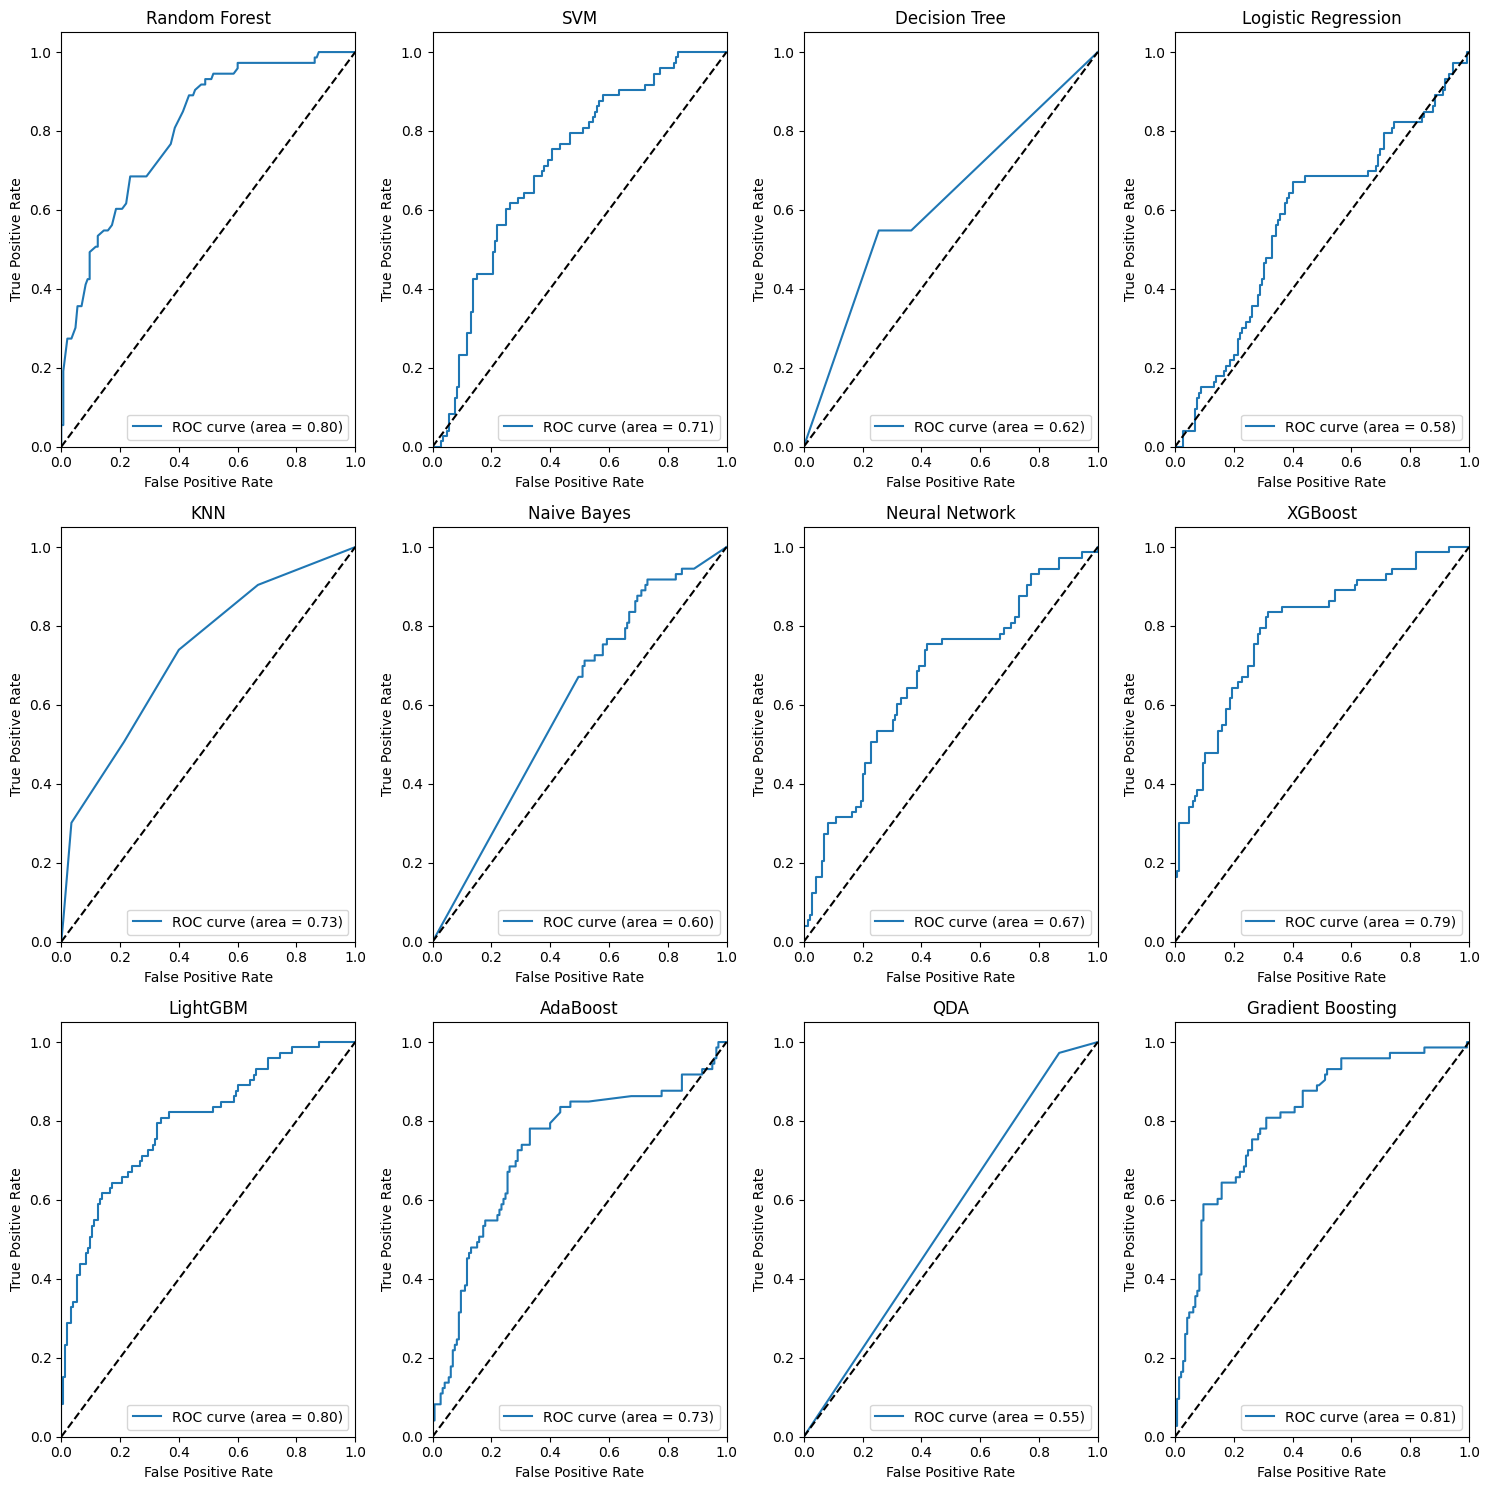

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(15, 15))




for i, row in df_results.iterrows():
    fpr, tpr, _ = roc_curve(y_test, row['y_scores'])
    roc_auc = auc(fpr, tpr)
    ax = axs[i // 4, i % 4]
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(row['name'])
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


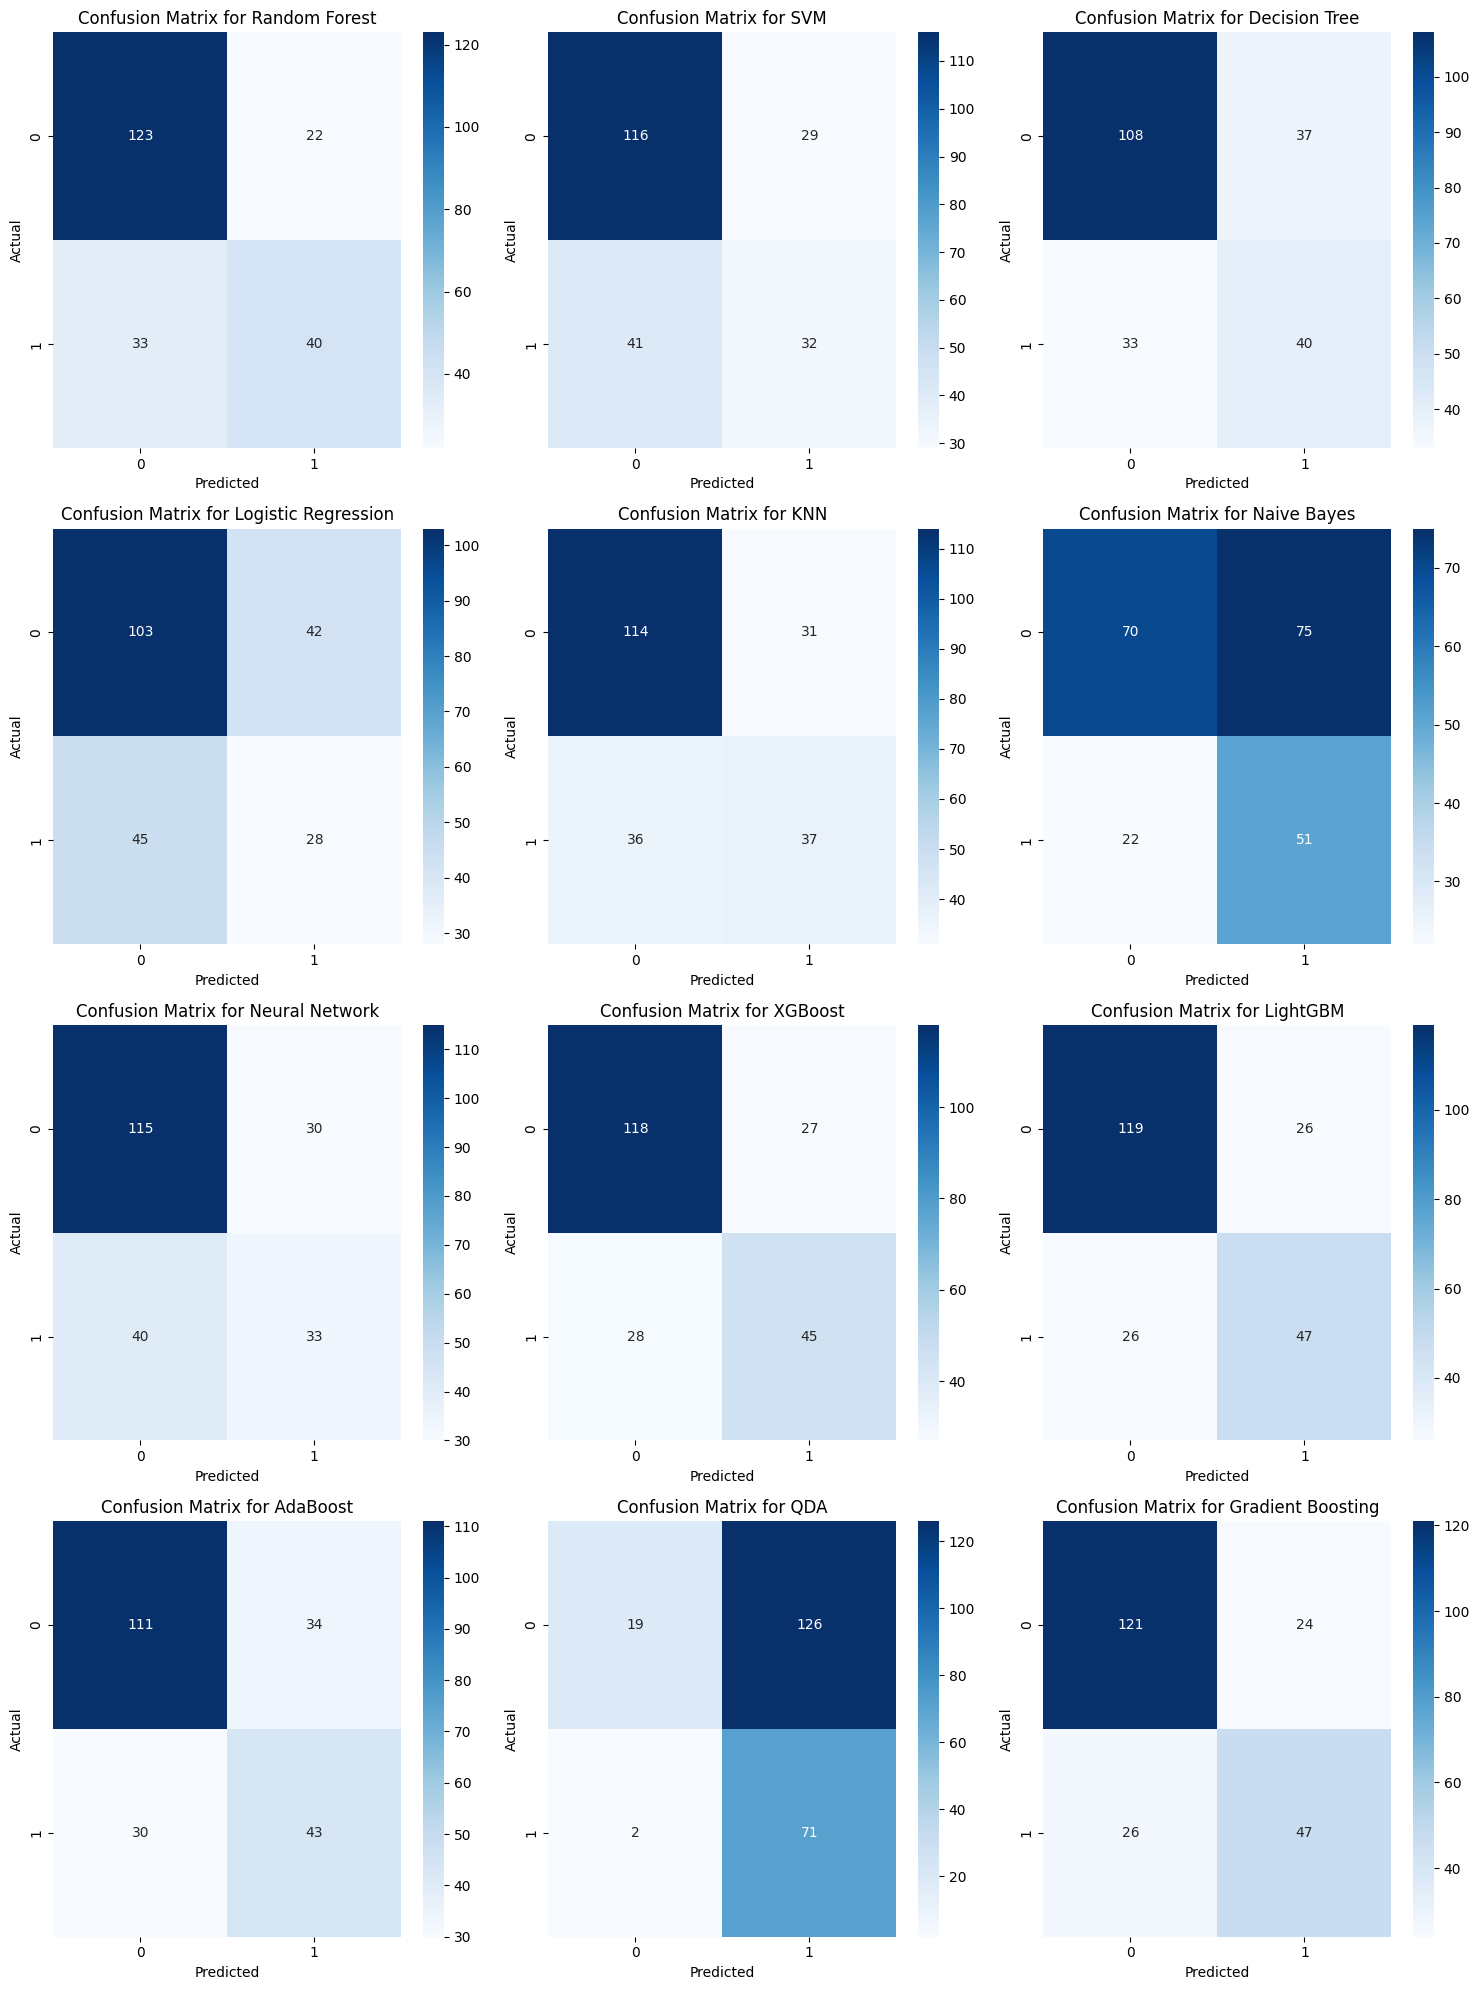

In [62]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# assert subplots matches the number of models
assert len(axs.flatten()) >= len(results)

# Plot the confusion matrix for each model
for i, result in enumerate(results):
    ax = axs.flatten()[i]

    name = result['name']
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {name}')

# If there are more subplots than models, hide the extra subplots
for j in range(i+1, len(axs.flatten())):
    axs.flatten()[j].axis('off')

plt.tight_layout()
plt.show()


